In [28]:
from tensorflow import keras 
import numpy as np 
import sklearn

In [29]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K
# Train-Test
from sklearn.model_selection import train_test_split
# Scaling data
from sklearn.preprocessing import StandardScaler
# Classification Report
from sklearn.metrics import classification_report

from keras.utils import to_categorical


In [30]:
# load dataset
df = pd.read_csv("/localscratch/df_preprocessed.csv")
df.shape

(1677867, 30)

In [31]:
df.keys()

Index(['Type', 'PT_l0', 'PT_l1', 'PT_l2', 'met', 'delR_l0l1', 'delR_l0l2',
       'delR_l1l2', 'delEta_l0l1', 'delEta_l0l2', 'delEta_l1l2', 'dPhi_MET_l0',
       'dPhi_MET_l1', 'dPhi_MET_l2', 'max_PT_jet', 'd0_l0', 'd0_l1', 'd0_l2',
       'z0sintheta_l0', 'z0sintheta_l1', 'z0sintheta_l2', 'n_btag', 'mT_l0l1',
       'mT_l0l2', 'mT_l1l2', 'sumPT', 'm_l0l1', 'm_l0l2', 'm_l1l2', 'm_lll'],
      dtype='object')

In [32]:
x = df.drop('Type', axis=1)
x.shape

(1677867, 29)

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = pd.DataFrame(sc.fit_transform(x))

Y = df['Type'].values
print(Y)

y_cat = to_categorical(Y, num_classes=3)
print(y_cat)
print(x.values)

[1 1 1 ... 2 2 2]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[-0.47057967 -0.14251873  1.34747411 ...  0.67225207  1.03368125
   1.15176801]
 [-0.47057967 -0.82510717 -0.33154205 ...  0.06548656 -0.61163734
  -0.23695372]
 [-0.47057967 -0.53112573  1.06903262 ...  0.61396505  0.08536732
   0.38089112]
 ...
 [-0.39784018  0.33142598 -0.47308185 ... -0.27810984  0.16178228
  -0.08823041]
 [-0.39784018  0.33142598 -0.64368563 ... -0.50652978 -0.16820158
  -0.38274929]
 [-0.39784018  0.33142598 -0.77305988 ... -0.53707316 -0.20213949
  -0.4161443 ]]


In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.2)
print(y_train)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [35]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
print(class_weight)

[5.59882475 4.76806281 0.3828979 ]


In [36]:
class_weight = {0: 5.59882475, 
                1: 4.76806281, 
                2: 0.3828979}

In [37]:
callback = keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=3,
    verbose=0,
    mode="auto",
)

In [39]:
model = Sequential()
model.add(Dense(34, input_shape = (29,), activation = "swish"))
model.add(Dense(80, activation = "swish"))
model.add(Dropout(0.37))
model.add(Dense(32, activation = "swish"))
model.add(Dropout(0.3))
model.add(Dense(16, activation = "swish"))
model.add(Dropout(0.26))
model.add(Dense(3, activation = "softmax"))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 34)                1020      
                                                                 
 dense_17 (Dense)            (None, 80)                2800      
                                                                 
 dropout_14 (Dropout)        (None, 80)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2592      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dropout_16 (Dropout)        (None, 16)               

In [41]:
model.fit(x_train, y_train, verbose=1, epochs=2, class_weight = class_weight, callbacks=[callback])

Epoch 1/2
41947/41947 [==============================] - 56s 1ms/step - loss: 0.8313 - accuracy: 0.5406
Epoch 2/2
41947/41947 [==============================] - 55s 1ms/step - loss: 0.7271 - accuracy: 0.5726


In [42]:
pred_train= model.predict(x_train)

scores = model.evaluate(x_train, y_train, verbose=0)

print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

 

pred_test= model.predict(x_test)

scores2 = model.evaluate(x_test, y_test, verbose=0)

print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    


41947/41947 [==============================] - 28s 657us/step
Accuracy on training data: 0.5677560567855835% 
 Error on training data: 0.4322439432144165
10487/10487 [==============================] - 7s 671us/step
Accuracy on test data: 0.5672370195388794% 
 Error on test data: 0.4327629804611206


In [43]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print(y_pred)
y_test_class = np.argmax(y_test, axis=1)
#confusion_matrix(y_test_class, y_pred_class)

10487/10487 [==============================] - 7s 665us/step
[[1.5201909e-05 7.1449739e-01 2.8548744e-01]
 [7.7656323e-06 7.9965955e-01 2.0033275e-01]
 [3.5218671e-01 5.5530107e-01 9.2512205e-02]
 ...
 [5.0642733e-02 6.2458158e-01 3.2477561e-01]
 [5.4214400e-01 5.6612238e-02 4.0124372e-01]
 [1.9389349e-03 3.9690703e-02 9.5837033e-01]]


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.19      0.84      0.32     20002
           1       0.21      0.81      0.33     23474
           2       0.98      0.53      0.69    292098

    accuracy                           0.57    335574
   macro avg       0.46      0.73      0.44    335574
weighted avg       0.88      0.57      0.64    335574



In [18]:
# Creating  a confusion matrix,which compares the y_test and y_pred
print(y_test[:,0])
print(y_pred[:,0])
cm = confusion_matrix(y_test[:,0], y_pred[:,0])

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['SETOSA','VERSICOLR','VIRGINICA'], 
                     columns = ['SETOSA','VERSICOLR','VIRGINICA'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


[0. 0. 0. ... 0. 0. 0.]
[0.04367728 0.00297935 0.02908239 ... 0.02162288 0.00096228 0.4098848 ]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

[0.19, 0.84, 0.32]
[0.21, 0.81, 0.33]
[0.98, 0.53, 0.69]
plotMat: [[0.19, 0.84, 0.32], [0.21, 0.81, 0.33], [0.98, 0.53, 0.69]]
support: [20002, 23474, 292098]


ImportError: cannot import name 'izip' from 'itertools' (unknown location)

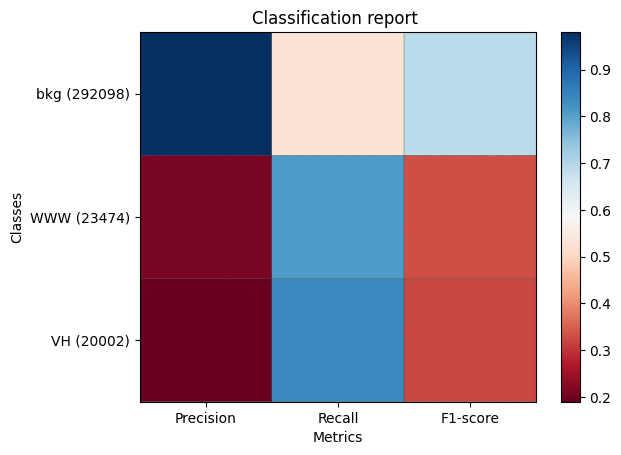

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib
    '''
    from itertools import izip
    pc.update_scalarmappable()
    ax = pc.get_axes()
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = ['VH', 'WWW', 'bkg']
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():
    sampleClassificationReport = """           precision    recall  f1-score   support

           0       0.19      0.84      0.32     20002
           1       0.21      0.81      0.33     23474
           2       0.98      0.53      0.69    292098

"""


    plot_classification_report(sampleClassificationReport)
    plt.close()

if __name__ == "__main__":
    main()
    plt.savefig('/localscratch/classif_report.png', dpi=200, format='png', bbox_inches='tight')
    #cProfile.run('main()') # if you want to do some profiling


In [ ]:
FPR, TPR, TH = roc_curve(y_test, y_score, sample_weight=class_weights, pos_label=1)
roc_auc = roc_auc_score(y_test, y_score)